Generating 4x4 Rush Hour puzzle with 2x1 blockers...
Searching for a complex puzzle (6+ moves)...
Found complex puzzle with 7 moves (seed 104)
Found complex puzzle with 8 moves (seed 106)
Found very complex puzzle with 8 moves!
Using complex puzzle with 8 moves
Initial puzzle:


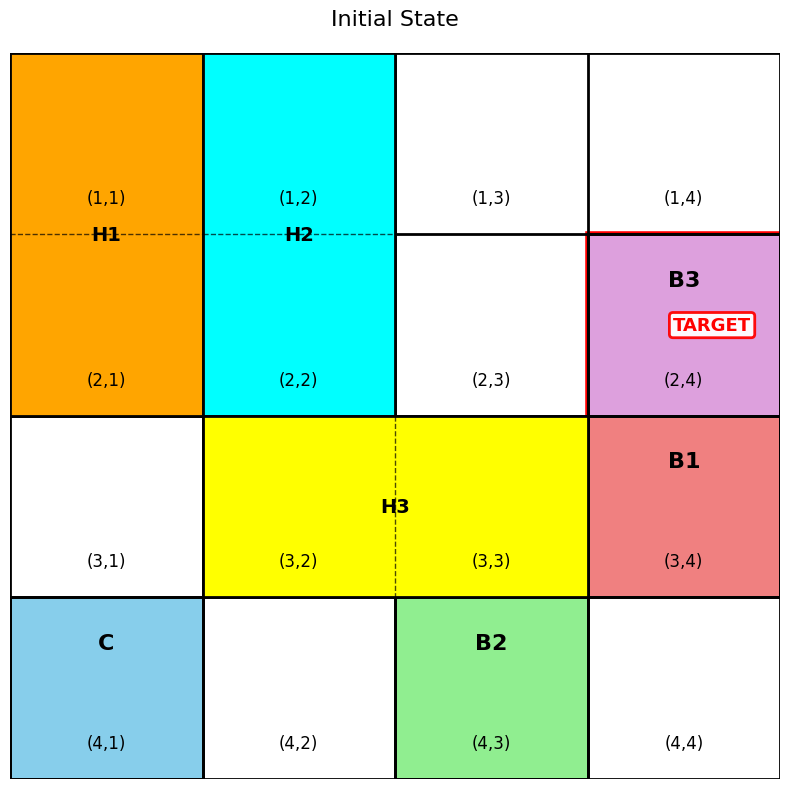


PUZZLE-SPECIFIC PROMPT:
Task Description: You are given a 4x4 Rush Hour puzzle. Your goal is to move the blue car (labeled "C") from its current position [4,1] to the TARGET cell at position [2,4] by moving pieces one square at a time.

Puzzle Pieces:
- Car "C" (blue): Currently at position [4,1] - This is the piece you need to get to the TARGET

- 1x1 Blockers (B1, B2, etc.): Single-cell obstacles that can be moved to clear a path
    - B3 at [2,4]
  - B1 at [3,4]
  - B2 at [4,3]

- 2x1 Blockers (H1, H2, etc.): Two-cell obstacles that move as a single unit
    - H1 (vertical) at [1,1], [2,1]
  - H2 (vertical) at [1,2], [2,2]
  - H3 (horizontal) at [3,2], [3,3]

- TARGET cell: Position [2,4] (marked with red border and "TARGET" label)

Movement Rules:
- Any piece (car "C", 1x1 blockers "B1, B2, etc.", or 2x1 blockers "H1, H2, etc.") can move UP, DOWN, LEFT, or RIGHT
- Each move is exactly ONE square in any direction for the entire piece
- For 2x1 blockers: The entire piece moves toget

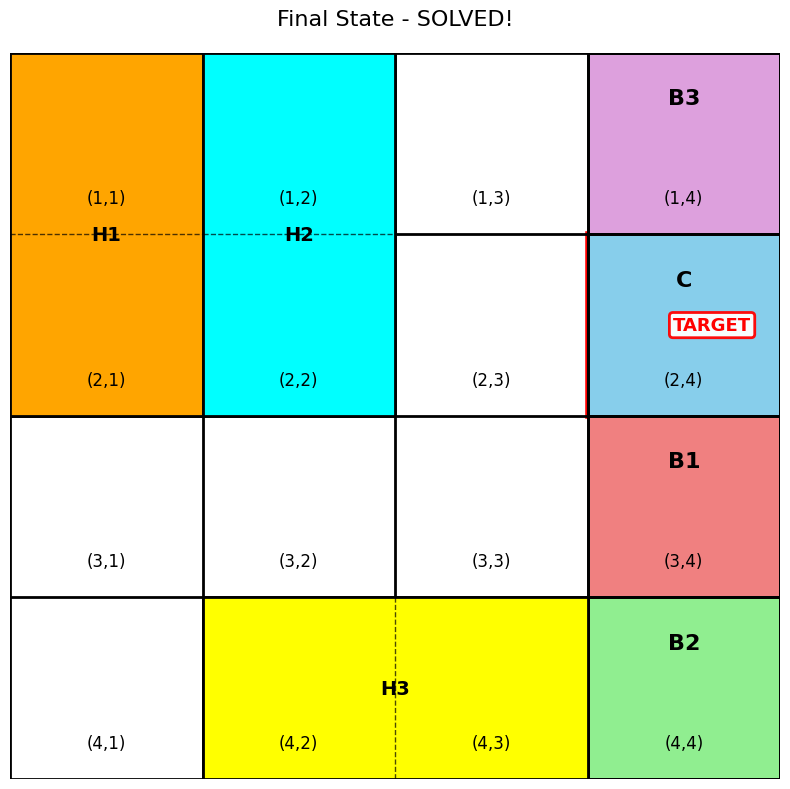


Puzzle Statistics:
- Grid size: 4x4
- Exit position: [2,4] (1-indexed)
- Total pieces: 10
- Solution length: 8 moves


In [8]:
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from collections import deque

# Configuration for 4x4 grid
GRID_SIZE = 4
EXIT_POS = (1, GRID_SIZE - 1)  # Exit at row 1 (0-indexed), rightmost column

class RushHour4x4:
    def __init__(self):
        self.grid_size = GRID_SIZE
        self.exit_pos = EXIT_POS
    
    def create_empty_grid(self):
        """Create empty 4x4 grid"""
        return [['.' for _ in range(self.grid_size)] for _ in range(self.grid_size)]
    
    def find_piece_positions(self, grid, piece_id):
        """Find all positions occupied by a piece"""
        positions = []
        for r in range(self.grid_size):
            for c in range(self.grid_size):
                if grid[r][c] == piece_id:
                    positions.append((r, c))
        return positions
    
    def can_place_piece(self, grid, positions):
        """Check if a piece can be placed at given positions"""
        for r, c in positions:
            if not (0 <= r < self.grid_size and 0 <= c < self.grid_size):
                return False
            if grid[r][c] != '.':
                return False
        return True
    
    def place_piece(self, grid, piece_id, positions):
        """Place a piece on the grid"""
        for r, c in positions:
            grid[r][c] = piece_id
    
    def remove_piece(self, grid, piece_id):
        """Remove a piece from the grid"""
        for r in range(self.grid_size):
            for c in range(self.grid_size):
                if grid[r][c] == piece_id:
                    grid[r][c] = '.'
    
    def get_all_empty_positions(self, grid):
        """Get all empty positions in the grid"""
        empty = []
        for r in range(self.grid_size):
            for c in range(self.grid_size):
                if grid[r][c] == '.':
                    empty.append((r, c))
        return empty
    
    def generate_2x1_positions(self, start_pos, orientation):
        """Generate positions for a 2x1 blocker"""
        r, c = start_pos
        if orientation == 'horizontal':
            return [(r, c), (r, c + 1)]
        else:  # vertical
            return [(r, c), (r + 1, c)]
    
    def generate_puzzle(self, num_1x1_blockers=3, num_2x1_blockers=2, max_attempts=1000):
        """Generate a random 4x4 Rush Hour puzzle"""
        for attempt in range(max_attempts):
            grid = self.create_empty_grid()
            
            # Place car (1x1) - not at exit position
            available_positions = [(r, c) for r in range(self.grid_size) 
                                 for c in range(self.grid_size) if (r, c) != self.exit_pos]
            
            car_pos = random.choice(available_positions)
            self.place_piece(grid, 'C', [car_pos])
            
            # Place 2x1 blockers first (they're more constrained)
            blockers_placed = 0
            for i in range(num_2x1_blockers):
                piece_id = f'H{i+1}'  # H for horizontal/2x1 pieces
                placed = False
                attempts_for_this_piece = 0
                
                while not placed and attempts_for_this_piece < 50:
                    # Try both orientations
                    orientation = random.choice(['horizontal', 'vertical'])
                    
                    # Get valid starting positions for this orientation
                    if orientation == 'horizontal':
                        valid_starts = [(r, c) for r in range(self.grid_size) 
                                      for c in range(self.grid_size - 1)]
                    else:  # vertical
                        valid_starts = [(r, c) for r in range(self.grid_size - 1) 
                                      for c in range(self.grid_size)]
                    
                    if valid_starts:
                        start_pos = random.choice(valid_starts)
                        positions = self.generate_2x1_positions(start_pos, orientation)
                        
                        if self.can_place_piece(grid, positions):
                            self.place_piece(grid, piece_id, positions)
                            placed = True
                            blockers_placed += 1
                    
                    attempts_for_this_piece += 1
            
            # Place 1x1 blockers
            for i in range(num_1x1_blockers):
                piece_id = f'B{i+1}'
                empty_positions = self.get_all_empty_positions(grid)
                
                if empty_positions:
                    pos = random.choice(empty_positions)
                    self.place_piece(grid, piece_id, [pos])
                    blockers_placed += 1
            
            # Check if we have enough blockers and the puzzle is solvable
            if blockers_placed >= (num_2x1_blockers + num_1x1_blockers - 1):  # Allow some flexibility
                solution = self.bfs_solve(grid)
                if solution is not None and len(solution) > 0:  # Must require at least 1 move
                    return grid
        
        raise Exception(f"Could not generate solvable puzzle after {max_attempts} attempts")
    
    def grid_to_tuple(self, grid):
        """Convert grid to hashable tuple"""
        return tuple(tuple(row) for row in grid)
    
    def tuple_to_grid(self, t):
        """Convert tuple back to grid"""
        return [list(row) for row in t]
    
    def is_solved(self, grid):
        """Check if car 'C' is at exit position"""
        return grid[self.exit_pos[0]][self.exit_pos[1]] == 'C'
    
    def get_piece_info(self, grid, piece_id):
        """Get information about a piece (positions and type)"""
        positions = self.find_piece_positions(grid, piece_id)
        if len(positions) == 1:
            return positions, '1x1'
        elif len(positions) == 2:
            # Determine if horizontal or vertical
            r1, c1 = positions[0]
            r2, c2 = positions[1]
            if r1 == r2:  # Same row
                return sorted(positions, key=lambda x: x[1]), 'horizontal'
            else:  # Same column
                return sorted(positions, key=lambda x: x[0]), 'vertical'
        return positions, 'unknown'
    
    def get_neighbors(self, state):
        """Get all valid neighboring states"""
        grid = self.tuple_to_grid(state)
        neighbors = []
        
        # Find all unique pieces
        pieces = set()
        for r in range(self.grid_size):
            for c in range(self.grid_size):
                if grid[r][c] != '.':
                    pieces.add(grid[r][c])
        
        # Try moving each piece in all 4 directions
        for piece_id in pieces:
            positions, piece_type = self.get_piece_info(grid, piece_id)
            
            for dr, dc in [(-1, 0), (1, 0), (0, -1), (0, 1)]:  # up, down, left, right
                # Calculate new positions
                new_positions = [(r + dr, c + dc) for r, c in positions]
                
                # Check if all new positions are valid
                valid_move = True
                for nr, nc in new_positions:
                    if not (0 <= nr < self.grid_size and 0 <= nc < self.grid_size):
                        valid_move = False
                        break
                
                if not valid_move:
                    continue
                
                # Check if all new positions are empty (excluding current piece positions)
                temp_grid = [row[:] for row in grid]
                self.remove_piece(temp_grid, piece_id)
                
                can_move = True
                for nr, nc in new_positions:
                    if temp_grid[nr][nc] != '.':
                        can_move = False
                        break
                
                if can_move:
                    # Create new state
                    new_grid = [row[:] for row in temp_grid]
                    self.place_piece(new_grid, piece_id, new_positions)
                    neighbors.append(self.grid_to_tuple(new_grid))
        
        return neighbors
    
    def bfs_solve(self, start_grid):
        """BFS solver that returns optimal solution path"""
        start_state = self.grid_to_tuple(start_grid)
        
        if self.is_solved(start_grid):
            return []  # Already solved
        
        queue = deque([(start_state, [])])
        visited = {start_state}
        
        while queue:
            current_state, path = queue.popleft()
            
            for next_state in self.get_neighbors(current_state):
                if next_state in visited:
                    continue
                
                visited.add(next_state)
                new_path = path + [next_state]
                
                if self.is_solved(self.tuple_to_grid(next_state)):
                    return new_path
                
                queue.append((next_state, new_path))
        
        return None  # No solution found
    
    def generate_solution_moves(self, start_grid, solution_path):
        """Generate text description of moves"""
        moves = []
        current_grid = start_grid
        
        for i, next_state in enumerate(solution_path):
            next_grid = self.tuple_to_grid(next_state)
            
            # Find what moved by comparing grids
            moved_piece = None
            old_positions = []
            new_positions = []
            
            # Find all unique pieces in current grid
            current_pieces = set()
            for r in range(self.grid_size):
                for c in range(self.grid_size):
                    if current_grid[r][c] != '.':
                        current_pieces.add(current_grid[r][c])
            
            # For each piece, check if it moved
            for piece in current_pieces:
                old_pos = self.find_piece_positions(current_grid, piece)
                new_pos = self.find_piece_positions(next_grid, piece)
                
                if old_pos != new_pos:
                    moved_piece = piece
                    old_positions = old_pos
                    new_positions = new_pos
                    break
            
            if moved_piece:
                # Convert to 1-indexed for display
                old_display = [(r+1, c+1) for r, c in old_positions]
                new_display = [(r+1, c+1) for r, c in new_positions]
                
                if len(old_positions) == 1:
                    moves.append(f"Step {i+1}: {moved_piece} [{old_display[0][0]},{old_display[0][1]}] -> [{new_display[0][0]},{new_display[0][1]}]")
                else:
                    moves.append(f"Step {i+1}: {moved_piece} {old_display} -> {new_display}")
            
            current_grid = next_grid
        
        return moves
    
    def generate_puzzle_specific_prompt(self, grid):
        """Generate a customized prompt for the specific 4x4 puzzle"""
        # Find car position
        car_pos = self.find_piece_positions(grid, 'C')[0]
        
        # Convert to 1-indexed coordinates
        car_pos_1indexed = (car_pos[0] + 1, car_pos[1] + 1)
        exit_pos_1indexed = (self.exit_pos[0] + 1, self.exit_pos[1] + 1)
        
        # Find blockers and their positions
        blockers_1x1 = []
        blockers_2x1 = []
        
        pieces = set()
        for r in range(self.grid_size):
            for c in range(self.grid_size):
                cell = grid[r][c]
                if cell != '.' and cell != 'C' and cell not in pieces:
                    pieces.add(cell)
                    positions = self.find_piece_positions(grid, cell)
                    
                    if len(positions) == 1:
                        pos_1indexed = (positions[0][0] + 1, positions[0][1] + 1)
                        blockers_1x1.append(f"{cell} at [{pos_1indexed[0]},{pos_1indexed[1]}]")
                    else:
                        # 2x1 blocker
                        pos_1indexed = [(pos[0] + 1, pos[1] + 1) for pos in positions]
                        positions_str = ", ".join([f"[{p[0]},{p[1]}]" for p in pos_1indexed])
                        
                        # Determine orientation
                        if positions[0][0] == positions[1][0]:  # Same row
                            orientation = "horizontal"
                        else:  # Same column
                            orientation = "vertical"
                        
                        blockers_2x1.append(f"{cell} ({orientation}) at {positions_str}")
        
        prompt = f"""Task Description: You are given a 4x4 Rush Hour puzzle. Your goal is to move the blue car (labeled "C") from its current position [{car_pos_1indexed[0]},{car_pos_1indexed[1]}] to the TARGET cell at position [{exit_pos_1indexed[0]},{exit_pos_1indexed[1]}] by moving pieces one square at a time.

Puzzle Pieces:
- Car "C" (blue): Currently at position [{car_pos_1indexed[0]},{car_pos_1indexed[1]}] - This is the piece you need to get to the TARGET

- 1x1 Blockers (B1, B2, etc.): Single-cell obstacles that can be moved to clear a path
  {chr(10).join(f"  - {blocker}" for blocker in blockers_1x1) if blockers_1x1 else "  - None present"}

- 2x1 Blockers (H1, H2, etc.): Two-cell obstacles that move as a single unit
  {chr(10).join(f"  - {blocker}" for blocker in blockers_2x1) if blockers_2x1 else "  - None present"}

- TARGET cell: Position [{exit_pos_1indexed[0]},{exit_pos_1indexed[1]}] (marked with red border and "TARGET" label)

Movement Rules:
- Any piece (car "C", 1x1 blockers "B1, B2, etc.", or 2x1 blockers "H1, H2, etc.") can move UP, DOWN, LEFT, or RIGHT
- Each move is exactly ONE square in any direction for the entire piece
- For 2x1 blockers: The entire piece moves together as a unit (both cells move simultaneously)
- Pieces strictly CANNOT move outside the 4x4 grid
- Pieces strictly CANNOT move into occupied squares (i.e. squares that already have another piece)
- At ANY instant, there CANNOT be two pieces occupying the same square
- The same piece can move multiple times in a row if needed
- You win when car "C" reaches the TARGET cell

Strategy:
- The blockers may or may not be in your way - you may need to move them to create a clear path for the car
- 2x1 blockers take up two cells and move as a single unit, so plan their movements carefully
- Sometimes you need to move blockers temporarily to make space, then move them again
- Plan your moves carefully to avoid getting pieces stuck

Coordinate System:
- Use [row,col] format where [1,1] is top-left, [4,4] is bottom-right
- Each cell shows its coordinates in black text: (row,col)
- For 2x1 blockers, both occupied cells are shown in the piece description

Expected Output Format:
Wrap your solution in <solution> tags and provide it as a numbered list of moves in this exact format:

<solution>
Step 1: [PIECE] [start_position] -> [end_position]
Step 2: [PIECE] [start_position] -> [end_position]
...
</solution>

For 1x1 pieces (car "C" and blockers "B1", "B2", etc.):
- Use single coordinate: C [2,1] -> [2,2]

For 2x1 pieces (blockers "H1", "H2", etc.):
- List both coordinates: H1 [[1,1],[1,2]] -> [[2,1],[2,2]]

Example response format:
<solution>
Step 1: C [2,1] -> [2,2]
Step 2: H1 [[1,3],[1,4]] -> [[2,3],[2,4]]  
Step 3: B1 [3,2] -> [3,1]
Step 4: C [2,2] -> [2,4]
</solution>"""

        return prompt
    
    def draw_grid(self, grid, title="4x4 Rush Hour Puzzle", figsize=(8, 8)):
        """Draw the grid with pieces - improved label positioning"""
        fig, ax = plt.subplots(figsize=figsize)
        ax.set_xlim(0, self.grid_size)
        ax.set_ylim(0, self.grid_size)
        ax.set_xticks(range(self.grid_size + 1))
        ax.set_yticks(range(self.grid_size + 1))
        
        # Draw main grid lines
        for x in range(self.grid_size + 1):
            ax.plot([x, x], [0, self.grid_size], color='black', linewidth=2)
        for y in range(self.grid_size + 1):
            ax.plot([0, self.grid_size], [y, y], color='black', linewidth=2)
        
        ax.set_title(title, fontsize=16, pad=20)
        ax.invert_yaxis()
        
        # Draw exit target with complete border on all 4 sides
        er, ec = self.exit_pos
        # Draw the red border rectangle with all 4 sides highlighted
        target_rect = patches.Rectangle((ec, er), 1, 1,
                                      facecolor='none',
                                      edgecolor='red', linewidth=4)
        ax.add_patch(target_rect)
        
        # Color mapping
        colors = {
            'C': 'skyblue',
            'B1': 'lightcoral', 'B2': 'lightgreen', 'B3': 'plum', 
            'B4': 'khaki', 'B5': 'lightsalmon',
            'H1': 'orange', 'H2': 'cyan', 'H3': 'yellow',
            'H4': 'pink', 'H5': 'lightgray'
        }
        
        # Collect information about pieces for better label positioning
        piece_info = {}
        dotted_lines = []
        
        # First pass: collect all piece information
        drawn_pieces = set()
        for r in range(self.grid_size):
            for c in range(self.grid_size):
                cell = grid[r][c]
                if cell != '.' and cell not in drawn_pieces:
                    positions = self.find_piece_positions(grid, cell)
                    piece_info[cell] = positions
                    drawn_pieces.add(cell)
        
        # Draw pieces
        for piece_id, positions in piece_info.items():
            if len(positions) == 1:
                # 1x1 piece
                r, c = positions[0]
                ax.add_patch(
                    patches.Rectangle((c, r), 1, 1,
                                    facecolor=colors.get(piece_id, 'white'),
                                    edgecolor='black', linewidth=2)
                )
                # Draw piece label in upper part of cell
                ax.text(c + 0.5, r + 0.25, piece_id, ha='center', va='center',
                       fontsize=16, fontweight='bold')
            else:
                # 2x1 piece - draw as connected rectangle
                min_r = min(pos[0] for pos in positions)
                max_r = max(pos[0] for pos in positions)
                min_c = min(pos[1] for pos in positions)
                max_c = max(pos[1] for pos in positions)
                
                width = max_c - min_c + 1
                height = max_r - min_r + 1
                
                # Draw the unified rectangle
                ax.add_patch(
                    patches.Rectangle((min_c, min_r), width, height,
                                    facecolor=colors.get(piece_id, 'white'),
                                    edgecolor='black', linewidth=2,
                                    zorder=3)
                )
                
                # Add internal dotted line and position label on it
                if width == 2:  # Horizontal 2x1
                    # Dotted line at the middle vertical boundary
                    line_x = min_c + 1
                    line_y_start = min_r
                    line_y_end = min_r + 1
                    dotted_lines.append([(line_x, line_y_start), (line_x, line_y_end)])
                    
                    # Place label on the dotted line
                    label_x = line_x
                    label_y = min_r + 0.5
                    
                else:  # Vertical 2x1
                    # Dotted line at the middle horizontal boundary
                    line_x_start = min_c
                    line_x_end = min_c + 1
                    line_y = min_r + 1
                    dotted_lines.append([(line_x_start, line_y), (line_x_end, line_y)])
                    
                    # Place label on the dotted line
                    label_x = min_c + 0.5
                    label_y = line_y
                
                # Draw the piece label on the dotted line - no background box needed
                ax.text(label_x, label_y, piece_id, ha='center', va='center',
                       fontsize=14, fontweight='bold', zorder=5, color='black')
        
        # Draw dotted lines for 2x1 piece internal boundaries
        for line in dotted_lines:
            start, end = line
            ax.plot([start[0], end[0]], [start[1], end[1]], 
                   color='black', linewidth=1, linestyle='--', alpha=0.7, zorder=4)
        
        # Add coordinates in each cell - consistent positioning for all cells
        for r in range(self.grid_size):
            for c in range(self.grid_size):
                coord_text = f"({r+1},{c+1})"
                # Same positioning for all cells - bottom part of cell
                ax.text(c + 0.5, r + 0.8, coord_text, ha='center', va='center',
                       fontsize=12, color='black', fontweight='normal')
        
        # Add target label - positioned between piece label and coordinates
        # Place it in the middle-right area of the target cell
        ax.text(ec + 0.85, er + 0.5, 'TARGET', ha='right', va='center',
               fontsize=13, fontweight='bold', color='red',
               bbox=dict(boxstyle='round,pad=0.2', facecolor='white', 
                        alpha=0.95, edgecolor='red', linewidth=2))
        
        ax.axis('off')
        plt.tight_layout()
        plt.show()

# Generate and solve one example puzzle
print("Generating 4x4 Rush Hour puzzle with 2x1 blockers...")

# Create puzzle generator
game = RushHour4x4()

# Try different seeds to find a more complex puzzle
print("Searching for a complex puzzle (6+ moves)...")
complex_puzzle = None
complex_solution = None
best_moves = 0

for seed in range(100, 1000):  # Try many different seeds
    try:
        random.seed(seed)
        test_puzzle = game.generate_puzzle(num_1x1_blockers=3, num_2x1_blockers=3)  # More pieces for complexity
        test_solution = game.bfs_solve(test_puzzle)
        
        if test_solution and len(test_solution) >= 6:  # Looking for puzzles with 6+ moves
            print(f"Found complex puzzle with {len(test_solution)} moves (seed {seed})")
            if len(test_solution) > best_moves:
                best_moves = len(test_solution)
                complex_puzzle = test_puzzle
                complex_solution = test_solution
                
            # If we find a really complex one (8+ moves), use it
            if len(test_solution) >= 8:
                print(f"Found very complex puzzle with {len(test_solution)} moves!")
                break
                
    except Exception:
        continue

# Fall back to a moderately complex one if no very complex one found
if complex_puzzle is None:
    print("Searching for moderately complex puzzle (4+ moves)...")
    for seed in range(50, 500):
        try:
            random.seed(seed)
            test_puzzle = game.generate_puzzle(num_1x1_blockers=2, num_2x1_blockers=3)
            test_solution = game.bfs_solve(test_puzzle)
            
            if test_solution and len(test_solution) >= 4:
                complex_puzzle = test_puzzle
                complex_solution = test_solution
                best_moves = len(test_solution)
                print(f"Found moderately complex puzzle with {len(test_solution)} moves (seed {seed})")
                break
        except Exception:
            continue

# Use the complex puzzle we found, or generate a default one
if complex_puzzle is not None:
    puzzle = complex_puzzle
    print(f"Using complex puzzle with {best_moves} moves")
else:
    print("Falling back to default puzzle generation...")
    random.seed(123)  # Different seed for variety
    puzzle = game.generate_puzzle(num_1x1_blockers=3, num_2x1_blockers=2)

# Display initial state
print("Initial puzzle:")
game.draw_grid(puzzle, "Initial State")

# Generate and display puzzle-specific prompt
print("\n" + "="*80)
print("PUZZLE-SPECIFIC PROMPT:")
print("="*80)
prompt = game.generate_puzzle_specific_prompt(puzzle)
print(prompt)
print("="*80)

# Solve puzzle
print("\nSolving puzzle...")
solution = game.bfs_solve(puzzle)

if solution:
    print(f"✅ Solution found in {len(solution)} moves!")
    
    # Generate move descriptions
    moves = game.generate_solution_moves(puzzle, solution)
    print("\nOptimal solution:")
    for move in moves:
        print(move)
    
    # Show final state
    final_grid = game.tuple_to_grid(solution[-1])
    print(f"\nFinal state:")
    game.draw_grid(final_grid, "Final State - SOLVED!")
    
    # Display puzzle info
    print(f"\nPuzzle Statistics:")
    print(f"- Grid size: {GRID_SIZE}x{GRID_SIZE}")
    print(f"- Exit position: [{EXIT_POS[0]+1},{EXIT_POS[1]+1}] (1-indexed)")
    print(f"- Total pieces: {len([cell for row in puzzle for cell in row if cell != '.'])}")
    print(f"- Solution length: {len(solution)} moves")
else:
    print("❌ No solution found!")

In [7]:
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from collections import deque
import os
import hashlib

# Configuration for 4x4 grid
GRID_SIZE = 4
EXIT_POS = (1, GRID_SIZE - 1)  # Exit at row 1 (0-indexed), rightmost column

class RushHour4x4:
    def __init__(self):
        self.grid_size = GRID_SIZE
        self.exit_pos = EXIT_POS
    
    def create_empty_grid(self):
        """Create empty 4x4 grid"""
        return [['.' for _ in range(self.grid_size)] for _ in range(self.grid_size)]
    
    def find_piece_positions(self, grid, piece_id):
        """Find all positions occupied by a piece"""
        positions = []
        for r in range(self.grid_size):
            for c in range(self.grid_size):
                if grid[r][c] == piece_id:
                    positions.append((r, c))
        return positions
    
    def can_place_piece(self, grid, positions):
        """Check if a piece can be placed at given positions"""
        for r, c in positions:
            if not (0 <= r < self.grid_size and 0 <= c < self.grid_size):
                return False
            if grid[r][c] != '.':
                return False
        return True
    
    def place_piece(self, grid, piece_id, positions):
        """Place a piece on the grid"""
        for r, c in positions:
            grid[r][c] = piece_id
    
    def remove_piece(self, grid, piece_id):
        """Remove a piece from the grid"""
        for r in range(self.grid_size):
            for c in range(self.grid_size):
                if grid[r][c] == piece_id:
                    grid[r][c] = '.'
    
    def get_all_empty_positions(self, grid):
        """Get all empty positions in the grid"""
        empty = []
        for r in range(self.grid_size):
            for c in range(self.grid_size):
                if grid[r][c] == '.':
                    empty.append((r, c))
        return empty
    
    def generate_2x1_positions(self, start_pos, orientation):
        """Generate positions for a 2x1 blocker"""
        r, c = start_pos
        if orientation == 'horizontal':
            return [(r, c), (r, c + 1)]
        else:  # vertical
            return [(r, c), (r + 1, c)]
    
    def get_difficulty_config(self, puzzle_num, total_puzzles):
        """
        Get difficulty configuration based on puzzle number.
        Creates a good mix of easy, medium, and hard puzzles.
        """
        # Define difficulty levels with (num_1x1, num_2x1, difficulty_name)
        difficulty_configs = [
            # Easy: More 1x1, fewer 2x1
            (4, 0, "easy"),      # 4 single blocks, no 2x1 blocks
            (3, 1, "easy"),      # 3 single blocks, 1 double block
            (5, 0, "easy"),      # 5 single blocks, no 2x1 blocks
            
            # Medium: Balanced mix
            (2, 2, "medium"),    # 2 single blocks, 2 double blocks
            (3, 2, "medium"),    # 3 single blocks, 2 double blocks
            (1, 3, "medium"),    # 1 single block, 3 double blocks
            (4, 1, "medium"),    # 4 single blocks, 1 double block
            
            # Hard: More 2x1, strategic placement
            (0, 3, "hard"),      # No single blocks, 3 double blocks
            (1, 2, "hard"),      # 1 single block, 2 double blocks
            (2, 3, "hard"),      # 2 single blocks, 3 double blocks
            (0, 4, "hard"),      # No single blocks, 4 double blocks (max challenge)
        ]
        
        # Distribute difficulties across puzzles
        # 40% easy, 40% medium, 20% hard
        if puzzle_num <= total_puzzles * 0.4:
            # Easy puzzles (first 40%)
            easy_configs = [config for config in difficulty_configs if config[2] == "easy"]
            return random.choice(easy_configs)
        elif puzzle_num <= total_puzzles * 0.8:
            # Medium puzzles (next 40%)
            medium_configs = [config for config in difficulty_configs if config[2] == "medium"]
            return random.choice(medium_configs)
        else:
            # Hard puzzles (last 20%)
            hard_configs = [config for config in difficulty_configs if config[2] == "hard"]
            return random.choice(hard_configs)
    
    def generate_puzzle(self, num_1x1_blockers=3, num_2x1_blockers=2, max_attempts=1000):
        """Generate a random 4x4 Rush Hour puzzle"""
        for attempt in range(max_attempts):
            grid = self.create_empty_grid()
            
            # Place car (1x1) - not at exit position
            available_positions = [(r, c) for r in range(self.grid_size) 
                                 for c in range(self.grid_size) if (r, c) != self.exit_pos]
            
            car_pos = random.choice(available_positions)
            self.place_piece(grid, 'C', [car_pos])
            
            # Place 2x1 blockers first (they're more constrained)
            blockers_placed = 0
            for i in range(num_2x1_blockers):
                piece_id = f'H{i+1}'  # H for horizontal/2x1 pieces
                placed = False
                attempts_for_this_piece = 0
                
                while not placed and attempts_for_this_piece < 50:
                    # Try both orientations
                    orientation = random.choice(['horizontal', 'vertical'])
                    
                    # Get valid starting positions for this orientation
                    if orientation == 'horizontal':
                        valid_starts = [(r, c) for r in range(self.grid_size) 
                                      for c in range(self.grid_size - 1)]
                    else:  # vertical
                        valid_starts = [(r, c) for r in range(self.grid_size - 1) 
                                      for c in range(self.grid_size)]
                    
                    if valid_starts:
                        start_pos = random.choice(valid_starts)
                        positions = self.generate_2x1_positions(start_pos, orientation)
                        
                        if self.can_place_piece(grid, positions):
                            self.place_piece(grid, piece_id, positions)
                            placed = True
                            blockers_placed += 1
                    
                    attempts_for_this_piece += 1
            
            # Place 1x1 blockers
            for i in range(num_1x1_blockers):
                piece_id = f'B{i+1}'
                empty_positions = self.get_all_empty_positions(grid)
                
                if empty_positions:
                    pos = random.choice(empty_positions)
                    self.place_piece(grid, piece_id, [pos])
                    blockers_placed += 1
            
            # Check if we have enough blockers and the puzzle is solvable
            expected_total = num_2x1_blockers + num_1x1_blockers
            if blockers_placed >= max(1, expected_total - 1):  # Allow some flexibility
                solution = self.bfs_solve(grid)
                if solution is not None and len(solution) > 0:  # Must require at least 1 move
                    return grid
        
        raise Exception(f"Could not generate solvable puzzle after {max_attempts} attempts")
    
    def grid_to_tuple(self, grid):
        """Convert grid to hashable tuple"""
        return tuple(tuple(row) for row in grid)
    
    def tuple_to_grid(self, t):
        """Convert tuple back to grid"""
        return [list(row) for row in t]
    
    def is_solved(self, grid):
        """Check if car 'C' is at exit position"""
        return grid[self.exit_pos[0]][self.exit_pos[1]] == 'C'
    
    def get_piece_info(self, grid, piece_id):
        """Get information about a piece (positions and type)"""
        positions = self.find_piece_positions(grid, piece_id)
        if len(positions) == 1:
            return positions, '1x1'
        elif len(positions) == 2:
            # Determine if horizontal or vertical
            r1, c1 = positions[0]
            r2, c2 = positions[1]
            if r1 == r2:  # Same row
                return sorted(positions, key=lambda x: x[1]), 'horizontal'
            else:  # Same column
                return sorted(positions, key=lambda x: x[0]), 'vertical'
        return positions, 'unknown'
    
    def get_neighbors(self, state):
        """Get all valid neighboring states"""
        grid = self.tuple_to_grid(state)
        neighbors = []
        
        # Find all unique pieces
        pieces = set()
        for r in range(self.grid_size):
            for c in range(self.grid_size):
                if grid[r][c] != '.':
                    pieces.add(grid[r][c])
        
        # Try moving each piece in all 4 directions
        for piece_id in pieces:
            positions, piece_type = self.get_piece_info(grid, piece_id)
            
            for dr, dc in [(-1, 0), (1, 0), (0, -1), (0, 1)]:  # up, down, left, right
                # Calculate new positions
                new_positions = [(r + dr, c + dc) for r, c in positions]
                
                # Check if all new positions are valid
                valid_move = True
                for nr, nc in new_positions:
                    if not (0 <= nr < self.grid_size and 0 <= nc < self.grid_size):
                        valid_move = False
                        break
                
                if not valid_move:
                    continue
                
                # Check if all new positions are empty (excluding current piece positions)
                temp_grid = [row[:] for row in grid]
                self.remove_piece(temp_grid, piece_id)
                
                can_move = True
                for nr, nc in new_positions:
                    if temp_grid[nr][nc] != '.':
                        can_move = False
                        break
                
                if can_move:
                    # Create new state
                    new_grid = [row[:] for row in temp_grid]
                    self.place_piece(new_grid, piece_id, new_positions)
                    neighbors.append(self.grid_to_tuple(new_grid))
        
        return neighbors
    
    def bfs_solve_all_optimal(self, start_grid):
        """BFS solver that returns ALL optimal solutions (same shortest length)"""
        start_state = self.grid_to_tuple(start_grid)
        
        if self.is_solved(start_grid):
            return [[]]  # Already solved, one empty solution
        
        queue = deque([(start_state, [])])
        visited = {start_state: 0}  # state -> minimum steps to reach it
        solutions = []
        min_solution_length = None
        
        while queue:
            current_state, path = queue.popleft()
            current_steps = len(path)
            
            # If we found a longer path than minimum solution, stop
            if min_solution_length is not None and current_steps >= min_solution_length:
                continue
            
            # Get all possible next states
            for next_state in self.get_neighbors(current_state):
                next_steps = current_steps + 1
                
                # Check if this state leads to longer solution than we've found
                if min_solution_length is not None and next_steps >= min_solution_length:
                    continue
                    
                # Check if we've seen this state with fewer or equal steps
                if next_state in visited and visited[next_state] < next_steps:
                    continue
                    
                visited[next_state] = next_steps
                new_path = path + [next_state]
                
                # Check if this state is solved
                if self.is_solved(self.tuple_to_grid(next_state)):
                    if min_solution_length is None:
                        min_solution_length = next_steps
                        solutions = [new_path]
                    elif next_steps == min_solution_length:
                        solutions.append(new_path)
                    # Don't add to queue if solved
                else:
                    queue.append((next_state, new_path))
        
        return solutions if solutions else None
    
    def bfs_solve(self, start_grid):
        """BFS solver that returns ONE optimal solution"""
        all_solutions = self.bfs_solve_all_optimal(start_grid)
        return all_solutions[0] if all_solutions else None
    
    def verify_solution(self, start_grid, solution_path):
        """Verify that a solution path is valid"""
        if not solution_path:
            return self.is_solved(start_grid)
        
        current = self.grid_to_tuple(start_grid)
        
        for i, next_state in enumerate(solution_path):
            # Check that next_state is a valid neighbor of current
            valid_neighbors = self.get_neighbors(current)
            if next_state not in valid_neighbors:
                print(f"Invalid move at step {i+1}")
                return False
            current = next_state
        
        # Check final state is solved
        final_grid = self.tuple_to_grid(current)
        if not self.is_solved(final_grid):
            print("Final state is not solved")
            return False
        
        return True
    
    def generate_solution_moves(self, start_grid, solution_path):
        """Generate text description of moves"""
        moves = []
        current_grid = start_grid
        
        for i, next_state in enumerate(solution_path):
            next_grid = self.tuple_to_grid(next_state)
            
            # Find what moved by comparing grids
            moved_piece = None
            old_positions = []
            new_positions = []
            
            # Find all unique pieces in current grid
            current_pieces = set()
            for r in range(self.grid_size):
                for c in range(self.grid_size):
                    if current_grid[r][c] != '.':
                        current_pieces.add(current_grid[r][c])
            
            # For each piece, check if it moved
            for piece in current_pieces:
                old_pos = self.find_piece_positions(current_grid, piece)
                new_pos = self.find_piece_positions(next_grid, piece)
                
                if old_pos != new_pos:
                    moved_piece = piece
                    old_positions = old_pos
                    new_positions = new_pos
                    break
            
            if moved_piece:
                # Convert to 1-indexed for display
                old_display = [(r+1, c+1) for r, c in old_positions]
                new_display = [(r+1, c+1) for r, c in new_positions]
                
                if len(old_positions) == 1:
                    moves.append(f"Step {i+1}: {moved_piece} [{old_display[0][0]},{old_display[0][1]}] -> [{new_display[0][0]},{new_display[0][1]}]")
                else:
                    moves.append(f"Step {i+1}: {moved_piece} {old_display} -> {new_display}")
            
            current_grid = next_grid
        
        return moves
    
    def generate_puzzle_specific_prompt(self, grid):
        """Generate a customized prompt for the specific 4x4 puzzle"""
        # Find car position
        car_pos = self.find_piece_positions(grid, 'C')[0]
        
        # Convert to 1-indexed coordinates
        car_pos_1indexed = (car_pos[0] + 1, car_pos[1] + 1)
        exit_pos_1indexed = (self.exit_pos[0] + 1, self.exit_pos[1] + 1)
        
        # Find blockers and their positions
        blockers_1x1 = []
        blockers_2x1 = []
        
        pieces = set()
        for r in range(self.grid_size):
            for c in range(self.grid_size):
                cell = grid[r][c]
                if cell != '.' and cell != 'C' and cell not in pieces:
                    pieces.add(cell)
                    positions = self.find_piece_positions(grid, cell)
                    
                    if len(positions) == 1:
                        pos_1indexed = (positions[0][0] + 1, positions[0][1] + 1)
                        blockers_1x1.append(f"{cell} at [{pos_1indexed[0]},{pos_1indexed[1]}]")
                    else:
                        # 2x1 blocker
                        pos_1indexed = [(pos[0] + 1, pos[1] + 1) for pos in positions]
                        positions_str = ", ".join([f"[{p[0]},{p[1]}]" for p in pos_1indexed])
                        
                        # Determine orientation
                        if positions[0][0] == positions[1][0]:  # Same row
                            orientation = "horizontal"
                        else:  # Same column
                            orientation = "vertical"
                        
                        blockers_2x1.append(f"{cell} ({orientation}) at {positions_str}")
        
        prompt = f"""Task Description: You are given a 4x4 Rush Hour puzzle. Your goal is to move the blue car (labeled "C") from its current position [{car_pos_1indexed[0]},{car_pos_1indexed[1]}] to the TARGET cell at position [{exit_pos_1indexed[0]},{exit_pos_1indexed[1]}] by moving pieces one square at a time.

Puzzle Pieces:
- Car "C" (blue): Currently at position [{car_pos_1indexed[0]},{car_pos_1indexed[1]}] - This is the piece you need to get to the TARGET

- 1x1 Blockers (B1, B2, etc.): Single-cell obstacles that can be moved to clear a path
  {chr(10).join(f"  - {blocker}" for blocker in blockers_1x1) if blockers_1x1 else "  - None present"}

- 2x1 Blockers (H1, H2, etc.): Two-cell obstacles that move as a single unit
  {chr(10).join(f"  - {blocker}" for blocker in blockers_2x1) if blockers_2x1 else "  - None present"}

- TARGET cell: Position [{exit_pos_1indexed[0]},{exit_pos_1indexed[1]}] (marked with red border and "TARGET" label)

Movement Rules:
- Any piece (car "C", 1x1 blockers "B1, B2, etc.", or 2x1 blockers "H1, H2, etc.") can move UP, DOWN, LEFT, or RIGHT
- Each move is exactly ONE square in any direction for the entire piece
- For 2x1 blockers: The entire piece moves together as a unit (both cells move simultaneously)
- Pieces strictly CANNOT move outside the 4x4 grid
- Pieces strictly CANNOT move into occupied squares (i.e. squares that already have another piece)
- At ANY instant, there CANNOT be two pieces occupying the same square
- The same piece can move multiple times in a row if needed
- You win when car "C" reaches the TARGET cell

Strategy:
- The blockers may or may not be in your way - you may need to move them to create a clear path for the car
- 2x1 blockers take up two cells and move as a single unit, so plan their movements carefully
- Sometimes you need to move blockers temporarily to make space, then move them again
- Plan your moves carefully to avoid getting pieces stuck

Coordinate System:
- Use [row,col] format where [1,1] is top-left, [4,4] is bottom-right
- Each cell shows its coordinates in black text: (row,col)
- For 2x1 blockers, both occupied cells are shown in the piece description

Expected Output Format:
Wrap your solution in <solution> tags and provide it as a numbered list of moves in this exact format:

<solution>
Step 1: [PIECE] [start_position] -> [end_position]
Step 2: [PIECE] [start_position] -> [end_position]
...
</solution>

For 1x1 pieces (car "C" and blockers "B1", "B2", etc.):
- Use single coordinate: C [2,1] -> [2,2]

For 2x1 pieces (blockers "H1", "H2", etc.):
- List both coordinates: H1 [[1,1],[1,2]] -> [[2,1],[2,2]]

Example response format:
<solution>
Step 1: C [2,1] -> [2,2]
Step 2: H1 [[1,3],[1,4]] -> [[2,3],[2,4]]  
Step 3: B1 [3,2] -> [3,1]
Step 4: C [2,2] -> [2,4]
</solution>"""

        return prompt
    
    def draw_grid(self, grid, title="4x4 Rush Hour Puzzle", save_path=None, figsize=(8, 8)):
        """Draw the grid with pieces - improved label positioning"""
        fig, ax = plt.subplots(figsize=figsize)
        ax.set_xlim(0, self.grid_size)
        ax.set_ylim(0, self.grid_size)
        ax.set_xticks(range(self.grid_size + 1))
        ax.set_yticks(range(self.grid_size + 1))
        
        # Draw main grid lines
        for x in range(self.grid_size + 1):
            ax.plot([x, x], [0, self.grid_size], color='black', linewidth=2)
        for y in range(self.grid_size + 1):
            ax.plot([0, self.grid_size], [y, y], color='black', linewidth=2)
        
        if title:
            ax.set_title(title, fontsize=16, pad=20)
        ax.invert_yaxis()
        
        # Draw exit target with complete border on all 4 sides - increased width
        er, ec = self.exit_pos
        target_rect = patches.Rectangle((ec, er), 1, 1,
                                      facecolor='none',
                                      edgecolor='red', linewidth=6)
        ax.add_patch(target_rect)
        
        # Color mapping
        colors = {
            'C': 'skyblue',
            'B1': 'lightcoral', 'B2': 'lightgreen', 'B3': 'plum', 
            'B4': 'khaki', 'B5': 'lightsalmon', 'B6': 'lightsteelblue',
            'H1': 'orange', 'H2': 'cyan', 'H3': 'yellow',
            'H4': 'pink', 'H5': 'lightgray', 'H6': 'lavender'
        }
        
        # Collect information about pieces for better label positioning
        piece_info = {}
        dotted_lines = []
        
        # First pass: collect all piece information
        drawn_pieces = set()
        for r in range(self.grid_size):
            for c in range(self.grid_size):
                cell = grid[r][c]
                if cell != '.' and cell not in drawn_pieces:
                    positions = self.find_piece_positions(grid, cell)
                    piece_info[cell] = positions
                    drawn_pieces.add(cell)
        
        # Draw pieces
        for piece_id, positions in piece_info.items():
            if len(positions) == 1:
                # 1x1 piece
                r, c = positions[0]
                ax.add_patch(
                    patches.Rectangle((c, r), 1, 1,
                                    facecolor=colors.get(piece_id, 'white'),
                                    edgecolor='black', linewidth=2)
                )
                # Draw piece label in upper part of cell
                ax.text(c + 0.5, r + 0.25, piece_id, ha='center', va='center',
                       fontsize=16, fontweight='bold')
            else:
                # 2x1 piece - draw as connected rectangle
                min_r = min(pos[0] for pos in positions)
                max_r = max(pos[0] for pos in positions)
                min_c = min(pos[1] for pos in positions)
                max_c = max(pos[1] for pos in positions)
                
                width = max_c - min_c + 1
                height = max_r - min_r + 1
                
                # Draw the unified rectangle
                ax.add_patch(
                    patches.Rectangle((min_c, min_r), width, height,
                                    facecolor=colors.get(piece_id, 'white'),
                                    edgecolor='black', linewidth=2,
                                    zorder=3)
                )
                
                # Add internal dotted line and position label on it
                if width == 2:  # Horizontal 2x1
                    # Dotted line at the middle vertical boundary
                    line_x = min_c + 1
                    line_y_start = min_r
                    line_y_end = min_r + 1
                    dotted_lines.append([(line_x, line_y_start), (line_x, line_y_end)])
                    
                    # Place label on the dotted line
                    label_x = line_x
                    label_y = min_r + 0.5
                    
                else:  # Vertical 2x1
                    # Dotted line at the middle horizontal boundary
                    line_x_start = min_c
                    line_x_end = min_c + 1
                    line_y = min_r + 1
                    dotted_lines.append([(line_x_start, line_y), (line_x_end, line_y)])
                    
                    # Place label on the dotted line
                    label_x = min_c + 0.5
                    label_y = line_y
                
                # Draw the piece label on the dotted line
                ax.text(label_x, label_y, piece_id, ha='center', va='center',
                       fontsize=14, fontweight='bold', zorder=5, color='black')
        
        # Draw dotted lines for 2x1 piece internal boundaries
        for line in dotted_lines:
            start, end = line
            ax.plot([start[0], end[0]], [start[1], end[1]], 
                   color='black', linewidth=1, linestyle='--', alpha=0.7, zorder=4)
        
        # Add coordinates in each cell - consistent positioning for all cells
        for r in range(self.grid_size):
            for c in range(self.grid_size):
                coord_text = f"({r+1},{c+1})"
                # Same positioning for all cells - bottom part of cell
                ax.text(c + 0.5, r + 0.8, coord_text, ha='center', va='center',
                       fontsize=12, color='black', fontweight='normal')
        
        # Add target label - positioned between piece label and coordinates
        # Place it in the middle-right area of the target cell
        ax.text(ec + 0.85, er + 0.5, 'TARGET', ha='right', va='center',
               fontsize=13, fontweight='bold', color='red',
               bbox=dict(boxstyle='round,pad=0.2', facecolor='white', 
                        alpha=0.95, edgecolor='red', linewidth=2))
        
        ax.axis('off')
        
        if save_path:
            plt.savefig(save_path, bbox_inches='tight', dpi=150)
            plt.close()
        else:
            plt.tight_layout()
            plt.show()
    
    def get_grid_hash(self, grid):
        """Generate a hash for a grid to check uniqueness"""
        grid_str = str(self.grid_to_tuple(grid))
        return hashlib.md5(grid_str.encode()).hexdigest()
    
    # Transformation functions for augmentations
    def rotate_90_clockwise(self, grid):
        """Rotate grid 90 degrees clockwise"""
        return [[grid[self.grid_size-1-j][i] for j in range(self.grid_size)] for i in range(self.grid_size)]
    
    def flip_horizontal(self, grid):
        """Flip grid horizontally"""
        return [row[::-1] for row in grid]
    
    def flip_vertical(self, grid):
        """Flip grid vertically"""
        return grid[::-1]
    
    def apply_transformation(self, grid, transformation):
        """Apply transformation and return new grid with updated exit position"""
        if transformation == "original":
            return grid, (2, 4)  # 1-indexed for 4x4: row 2, col 4
        elif transformation == "90_rotation":
            new_grid = self.rotate_90_clockwise(grid)
            return new_grid, (4, 3)  # 1-indexed: row 4, col 3
        elif transformation == "180_rotation":
            new_grid = self.rotate_90_clockwise(self.rotate_90_clockwise(grid))
            return new_grid, (3, 1)  # 1-indexed: row 3, col 1
        elif transformation == "270_rotation":
            new_grid = self.rotate_90_clockwise(self.rotate_90_clockwise(self.rotate_90_clockwise(grid)))
            return new_grid, (1, 2)  # 1-indexed: row 1, col 2
        elif transformation == "horizontal_flip":
            new_grid = self.flip_horizontal(grid)
            return new_grid, (2, 1)  # 1-indexed: row 2, col 1
        elif transformation == "vertical_flip":
            new_grid = self.flip_vertical(grid)
            return new_grid, (3, 4)  # 1-indexed: row 3, col 4
    
    def create_dataset(self, num_puzzles=150, base_folder="data/4x4"):
        """Create comprehensive dataset with puzzles and transformations"""
        if not os.path.exists(base_folder):
            os.makedirs(base_folder)
        
        transformations = ["original", "90_rotation", "180_rotation", "270_rotation", "horizontal_flip", "vertical_flip"]
        
        successful_puzzles = 0
        attempts = 0
        seen_hashes = set()  # Track all unique puzzle configurations
        
        while successful_puzzles < num_puzzles:
            attempts += 1
            if attempts > num_puzzles * 50:  # Increased safety break
                print(f"Warning: Only generated {successful_puzzles} puzzles after {attempts} attempts")
                break
                
            try:
                # Generate base puzzle with varying difficulty based on puzzle number
                random.seed(attempts * 193 + 7919)  # Different seed each time
                num_1x1, num_2x1, difficulty = self.get_difficulty_config(successful_puzzles + 1, num_puzzles)
                
                # Generate puzzle with the selected configuration
                base_puzzle = self.generate_puzzle(num_1x1_blockers=num_1x1, num_2x1_blockers=num_2x1)
                
                # Check if any transformation of this puzzle already exists
                transformations_valid = True
                transformation_hashes = []
                
                for transform_name in transformations:
                    transformed_grid, new_exit_pos_1indexed = self.apply_transformation(base_puzzle, transform_name)
                    
                    # Convert exit position back to 0-indexed for internal use
                    if transform_name == "original":
                        internal_exit_pos = (1, 3)  # 0-indexed: (1,3)
                    elif transform_name == "90_rotation":
                        internal_exit_pos = (3, 2)  # 0-indexed: (3,2)
                    elif transform_name == "180_rotation":
                        internal_exit_pos = (2, 0)  # 0-indexed: (2,0)
                    elif transform_name == "270_rotation":
                        internal_exit_pos = (0, 1)  # 0-indexed: (0,1)
                    elif transform_name == "horizontal_flip":
                        internal_exit_pos = (1, 0)  # 0-indexed: (1,0)
                    elif transform_name == "vertical_flip":
                        internal_exit_pos = (2, 3)  # 0-indexed: (2,3)
                    
                    # Temporarily update exit position for solving
                    old_exit_pos = self.exit_pos
                    self.exit_pos = internal_exit_pos
                    
                    try:
                        # Test if solvable
                        test_solution = self.bfs_solve(transformed_grid)
                        if test_solution is None:
                            transformations_valid = False
                            break
                        
                        # Check uniqueness
                        grid_hash = self.get_grid_hash(transformed_grid)
                        if grid_hash in seen_hashes:
                            transformations_valid = False
                            break
                        
                        transformation_hashes.append(grid_hash)
                        
                    finally:
                        self.exit_pos = old_exit_pos
                
                if not transformations_valid:
                    continue
                
                # All transformations are valid and unique, add hashes to seen set
                seen_hashes.update(transformation_hashes)
                
                puzzle_num = successful_puzzles + 1
                
                # Process each transformation
                for transform_name in transformations:
                    transformed_grid, new_exit_pos_1indexed = self.apply_transformation(base_puzzle, transform_name)
                    
                    # Convert exit position back to 0-indexed for internal use
                    if transform_name == "original":
                        internal_exit_pos = (1, 3)  # 0-indexed: (1,3)
                    elif transform_name == "90_rotation":
                        internal_exit_pos = (3, 2)  # 0-indexed: (3,2)
                    elif transform_name == "180_rotation":
                        internal_exit_pos = (2, 0)  # 0-indexed: (2,0)
                    elif transform_name == "270_rotation":
                        internal_exit_pos = (0, 1)  # 0-indexed: (0,1)
                    elif transform_name == "horizontal_flip":
                        internal_exit_pos = (1, 0)  # 0-indexed: (1,0)
                    elif transform_name == "vertical_flip":
                        internal_exit_pos = (2, 3)  # 0-indexed: (2,3)
                    
                    # Temporarily update exit position
                    old_exit_pos = self.exit_pos
                    self.exit_pos = internal_exit_pos
                    
                    try:
                        # Solve transformed puzzle and get ALL optimal solutions
                        all_solutions = self.bfs_solve_all_optimal(transformed_grid)
                        if all_solutions is None:
                            print(f"Skipping puzzle{puzzle_num}_{transform_name} - no solution")
                            continue
                        
                        # Create folder with proper naming
                        if transform_name == "original":
                            folder_name = f"puzzle{puzzle_num}"
                        else:
                            folder_name = f"puzzle{puzzle_num}_{transform_name}"
                        
                        puzzle_folder = os.path.join(base_folder, folder_name)
                        if not os.path.exists(puzzle_folder):
                            os.makedirs(puzzle_folder)
                        
                        # Generate and save puzzle-specific prompt
                        # Temporarily update exit_pos for prompt generation
                        temp_exit_pos = self.exit_pos
                        self.exit_pos = internal_exit_pos
                        puzzle_prompt = self.generate_puzzle_specific_prompt(transformed_grid)
                        self.exit_pos = temp_exit_pos
                        
                        prompt_file = os.path.join(puzzle_folder, "prompt.txt")
                        with open(prompt_file, 'w') as f:
                            f.write(puzzle_prompt)
                        
                        # Save initial puzzle
                        initial_path = os.path.join(puzzle_folder, "initial_state.png")
                        # Temporarily update exit_pos for drawing
                        temp_exit_pos = self.exit_pos
                        self.exit_pos = internal_exit_pos
                        self.draw_grid(transformed_grid, save_path=initial_path)
                        self.exit_pos = temp_exit_pos
                        
                        # Process each optimal solution
                        for sol_idx, solution in enumerate(all_solutions):
                            # Create subfolder for each solution if multiple exist
                            if len(all_solutions) > 1:
                                sol_folder = os.path.join(puzzle_folder, f"solution_{sol_idx + 1}")
                                if not os.path.exists(sol_folder):
                                    os.makedirs(sol_folder)
                            else:
                                sol_folder = puzzle_folder
                            
                            # Save solution steps
                            current_grid = transformed_grid
                            for step_num, next_state in enumerate(solution, 1):
                                step_grid = self.tuple_to_grid(next_state)
                                step_path = os.path.join(sol_folder, f"step_{step_num}.png")
                                # Temporarily update exit_pos for drawing
                                temp_exit_pos = self.exit_pos
                                self.exit_pos = internal_exit_pos
                                self.draw_grid(step_grid, save_path=step_path)
                                self.exit_pos = temp_exit_pos
                                current_grid = step_grid
                            
                            # Generate and save solution text
                            moves = self.generate_solution_moves(transformed_grid, solution)
                            
                            if len(all_solutions) > 1:
                                solution_file = os.path.join(sol_folder, "solution.txt")
                            else:
                                solution_file = os.path.join(puzzle_folder, "solution.txt")
                                
                            with open(solution_file, 'w') as f:
                                f.write(f"Puzzle: {folder_name}\n")
                                if len(all_solutions) > 1:
                                    f.write(f"Solution variant: {sol_idx + 1} of {len(all_solutions)}\n")
                                f.write(f"Total moves: {len(solution)}\n")
                                f.write(f"Exit position: [{new_exit_pos_1indexed[0]},{new_exit_pos_1indexed[1]}]\n")
                                f.write(f"Transformation: {transform_name}\n")
                                f.write(f"Difficulty: {difficulty} ({num_1x1} 1x1 blockers, {num_2x1} 2x1 blockers)\n")
                                f.write(f"Coordinate system: [row,col] where [1,1] is top-left (matches visual grid)\n\n")
                                f.write("Solution:\n")
                                for move in moves:
                                    f.write(move + "\n")
                        
                        # Create summary file if multiple solutions
                        if len(all_solutions) > 1:
                            summary_file = os.path.join(puzzle_folder, "solutions_summary.txt")
                            with open(summary_file, 'w') as f:
                                f.write(f"Puzzle: {folder_name}\n")
                                f.write(f"Total optimal solutions found: {len(all_solutions)}\n")
                                f.write(f"Optimal move count: {len(all_solutions[0])}\n")
                                f.write(f"Exit position: [{new_exit_pos_1indexed[0]},{new_exit_pos_1indexed[1]}]\n")
                                f.write(f"Transformation: {transform_name}\n")
                                f.write(f"Difficulty: {difficulty} ({num_1x1} 1x1 blockers, {num_2x1} 2x1 blockers)\n\n")
                                f.write("All solutions are stored in separate subfolders:\n")
                                for i in range(len(all_solutions)):
                                    f.write(f"- solution_{i + 1}/\n")
                        
                        solution_count = len(all_solutions)
                        print(f"✓ Created {folder_name} ({len(all_solutions[0])} moves, {solution_count} optimal solution{'s' if solution_count > 1 else ''}, {difficulty}: {num_1x1}×1x1 + {num_2x1}×2x1)")
                        
                    finally:
                        # Restore original exit position
                        self.exit_pos = old_exit_pos
                
                successful_puzzles += 1
                
            except Exception as e:
                print(f"Error generating puzzle {attempts}: {e}")
                continue
        
        print(f"\n🎉 4x4 Dataset creation complete!")
        print(f"Generated {successful_puzzles} base puzzles with transformations")
        print(f"Total puzzle variants: {successful_puzzles * len(transformations)}")
        print(f"Dataset saved in '{base_folder}' folder")
        
        # Print difficulty distribution summary
        easy_count = int(num_puzzles * 0.4)
        medium_count = int(num_puzzles * 0.4)
        hard_count = num_puzzles - easy_count - medium_count
        
        print(f"\nDifficulty Distribution:")
        print(f"- Easy puzzles: {easy_count} (40%) - More 1x1 blockers, fewer 2x1 blockers")
        print(f"- Medium puzzles: {medium_count} (40%) - Balanced mix of blockers")
        print(f"- Hard puzzles: {hard_count} (20%) - More 2x1 blockers, strategic placement")

# ----- Main Execution -----

if __name__ == "__main__":
    # Create 4x4 dataset
    print("Creating 4x4 Rush Hour dataset with varied difficulty...")
    game = RushHour4x4()
    game.create_dataset(num_puzzles=150)

Creating 4x4 Rush Hour dataset with varied difficulty...
✓ Created puzzle1 (4 moves, 1 optimal solution, easy: 3×1x1 + 1×2x1)
✓ Created puzzle1_90_rotation (4 moves, 1 optimal solution, easy: 3×1x1 + 1×2x1)
✓ Created puzzle1_180_rotation (4 moves, 1 optimal solution, easy: 3×1x1 + 1×2x1)
✓ Created puzzle1_270_rotation (4 moves, 1 optimal solution, easy: 3×1x1 + 1×2x1)
✓ Created puzzle1_horizontal_flip (4 moves, 1 optimal solution, easy: 3×1x1 + 1×2x1)
✓ Created puzzle1_vertical_flip (4 moves, 1 optimal solution, easy: 3×1x1 + 1×2x1)
✓ Created puzzle2 (2 moves, 1 optimal solution, easy: 4×1x1 + 0×2x1)
✓ Created puzzle2_90_rotation (2 moves, 1 optimal solution, easy: 4×1x1 + 0×2x1)
✓ Created puzzle2_180_rotation (2 moves, 1 optimal solution, easy: 4×1x1 + 0×2x1)
✓ Created puzzle2_270_rotation (2 moves, 1 optimal solution, easy: 4×1x1 + 0×2x1)
✓ Created puzzle2_horizontal_flip (2 moves, 1 optimal solution, easy: 4×1x1 + 0×2x1)
✓ Created puzzle2_vertical_flip (2 moves, 1 optimal solution, 

KeyboardInterrupt: 

In [1]:
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from collections import deque
import os
import hashlib

# Configuration for 4x4 grid
GRID_SIZE = 4
EXIT_POS = (1, GRID_SIZE - 1)  # Exit at row 1 (0-indexed), rightmost column

class RushHour4x4:
    def __init__(self):
        self.grid_size = GRID_SIZE
        self.exit_pos = EXIT_POS
    
    def create_empty_grid(self):
        """Create empty 4x4 grid"""
        return [['.' for _ in range(self.grid_size)] for _ in range(self.grid_size)]
    
    def find_piece_positions(self, grid, piece_id):
        """Find all positions occupied by a piece"""
        positions = []
        for r in range(self.grid_size):
            for c in range(self.grid_size):
                if grid[r][c] == piece_id:
                    positions.append((r, c))
        return positions
    
    def can_place_piece(self, grid, positions):
        """Check if a piece can be placed at given positions"""
        for r, c in positions:
            if not (0 <= r < self.grid_size and 0 <= c < self.grid_size):
                return False
            if grid[r][c] != '.':
                return False
        return True
    
    def place_piece(self, grid, piece_id, positions):
        """Place a piece on the grid"""
        for r, c in positions:
            grid[r][c] = piece_id
    
    def remove_piece(self, grid, piece_id):
        """Remove a piece from the grid"""
        for r in range(self.grid_size):
            for c in range(self.grid_size):
                if grid[r][c] == piece_id:
                    grid[r][c] = '.'
    
    def get_all_empty_positions(self, grid):
        """Get all empty positions in the grid"""
        empty = []
        for r in range(self.grid_size):
            for c in range(self.grid_size):
                if grid[r][c] == '.':
                    empty.append((r, c))
        return empty
    
    def generate_2x1_positions(self, start_pos, orientation):
        """Generate positions for a 2x1 blocker"""
        r, c = start_pos
        if orientation == 'horizontal':
            return [(r, c), (r, c + 1)]
        else:  # vertical
            return [(r, c), (r + 1, c)]
    
    def get_difficulty_config(self, puzzle_num, total_puzzles):
        """
        Get difficulty configuration based on puzzle number.
        Creates a good mix of easy, medium, and hard puzzles.
        """
        # Define difficulty levels with (num_1x1, num_2x1, difficulty_name)
        difficulty_configs = [
            # Easy
            (4, 0, "easy"),
            (3, 1, "easy"),
            (5, 0, "easy"),
            # Medium
            (2, 2, "medium"),
            (3, 2, "medium"),
            (1, 3, "medium"),
            (4, 1, "medium"),
            # Hard
            (0, 3, "hard"),
            (1, 2, "hard"),
            (2, 3, "hard"),
            (0, 4, "hard"),
        ]
        
        # Distribute difficulties across puzzles
        # 40% easy, 40% medium, 20% hard
        if puzzle_num <= total_puzzles * 0.4:
            easy_configs = [config for config in difficulty_configs if config[2] == "easy"]
            return random.choice(easy_configs)
        elif puzzle_num <= total_puzzles * 0.8:
            medium_configs = [config for config in difficulty_configs if config[2] == "medium"]
            return random.choice(medium_configs)
        else:
            hard_configs = [config for config in difficulty_configs if config[2] == "hard"]
            return random.choice(hard_configs)
    
    def generate_puzzle(self, num_1x1_blockers=3, num_2x1_blockers=2, max_attempts=1000):
        """Generate a random 4x4 Rush Hour puzzle"""
        for _ in range(max_attempts):
            grid = self.create_empty_grid()
            
            # Place car (1x1) - not at exit position
            available_positions = [(r, c) for r in range(self.grid_size) 
                                   for c in range(self.grid_size) if (r, c) != self.exit_pos]
            car_pos = random.choice(available_positions)
            self.place_piece(grid, 'C', [car_pos])
            
            # Place 2x1 blockers first
            blockers_placed = 0
            for i in range(num_2x1_blockers):
                piece_id = f'H{i+1}'  # H for 2x1 pieces
                placed = False
                attempts_for_this_piece = 0
                
                while not placed and attempts_for_this_piece < 50:
                    orientation = random.choice(['horizontal', 'vertical'])
                    if orientation == 'horizontal':
                        valid_starts = [(r, c) for r in range(self.grid_size) 
                                        for c in range(self.grid_size - 1)]
                    else:  # vertical
                        valid_starts = [(r, c) for r in range(self.grid_size - 1) 
                                        for c in range(self.grid_size)]
                    
                    if valid_starts:
                        start_pos = random.choice(valid_starts)
                        positions = self.generate_2x1_positions(start_pos, orientation)
                        if self.can_place_piece(grid, positions):
                            self.place_piece(grid, piece_id, positions)
                            placed = True
                            blockers_placed += 1
                    attempts_for_this_piece += 1
            
            # Place 1x1 blockers
            for i in range(num_1x1_blockers):
                piece_id = f'B{i+1}'
                empty_positions = self.get_all_empty_positions(grid)
                if empty_positions:
                    pos = random.choice(empty_positions)
                    self.place_piece(grid, piece_id, [pos])
                    blockers_placed += 1
            
            # Check if we have enough blockers and the puzzle is solvable
            expected_total = num_2x1_blockers + num_1x1_blockers
            if blockers_placed >= max(1, expected_total - 1):  # Allow some flexibility
                solution = self.bfs_solve(grid)
                if solution is not None and len(solution) > 0:  # At least 1 move
                    return grid
        
        raise Exception(f"Could not generate solvable puzzle after {max_attempts} attempts")
    
    def grid_to_tuple(self, grid):
        """Convert grid to hashable tuple"""
        return tuple(tuple(row) for row in grid)
    
    def tuple_to_grid(self, t):
        """Convert tuple back to grid"""
        return [list(row) for row in t]
    
    def is_solved(self, grid):
        """Check if car 'C' is at exit position"""
        return grid[self.exit_pos[0]][self.exit_pos[1]] == 'C'
    
    def get_piece_info(self, grid, piece_id):
        """Get information about a piece (positions and type)"""
        positions = self.find_piece_positions(grid, piece_id)
        if len(positions) == 1:
            return positions, '1x1'
        elif len(positions) == 2:
            r1, c1 = positions[0]
            r2, c2 = positions[1]
            if r1 == r2:
                return sorted(positions, key=lambda x: x[1]), 'horizontal'
            else:
                return sorted(positions, key=lambda x: x[0]), 'vertical'
        return positions, 'unknown'
    
    def get_neighbors(self, state):
        """Get all valid neighboring states (move any piece by 1 in any direction)"""
        grid = self.tuple_to_grid(state)
        neighbors = []
        
        # Find all unique pieces
        pieces = set()
        for r in range(self.grid_size):
            for c in range(self.grid_size):
                if grid[r][c] != '.':
                    pieces.add(grid[r][c])
        
        # Try moving each piece in all 4 directions
        for piece_id in pieces:
            positions, _ = self.get_piece_info(grid, piece_id)
            for dr, dc in [(-1, 0), (1, 0), (0, -1), (0, 1)]:  # up, down, left, right
                new_positions = [(r + dr, c + dc) for r, c in positions]
                
                # Bounds check
                valid_move = True
                for nr, nc in new_positions:
                    if not (0 <= nr < self.grid_size and 0 <= nc < self.grid_size):
                        valid_move = False
                        break
                if not valid_move:
                    continue
                
                # Collision check
                temp_grid = [row[:] for row in grid]
                self.remove_piece(temp_grid, piece_id)
                can_move = True
                for nr, nc in new_positions:
                    if temp_grid[nr][nc] != '.':
                        can_move = False
                        break
                if not can_move:
                    continue
                
                # Apply move
                new_grid = [row[:] for row in temp_grid]
                self.place_piece(new_grid, piece_id, new_positions)
                neighbors.append(self.grid_to_tuple(new_grid))
        
        return neighbors
    
    def bfs_solve_all_optimal(self, start_grid):
        """BFS solver that returns ALL optimal solutions (same shortest length)"""
        start_state = self.grid_to_tuple(start_grid)
        if self.is_solved(start_grid):
            return [[]]  # Already solved
        
        queue = deque([(start_state, [])])
        visited = {start_state: 0}  # state -> min steps
        solutions = []
        min_solution_length = None
        
        while queue:
            current_state, path = queue.popleft()
            current_steps = len(path)
            
            # If we found a longer path than minimum solution, prune
            if min_solution_length is not None and current_steps >= min_solution_length:
                continue
            
            for next_state in self.get_neighbors(current_state):
                next_steps = current_steps + 1
                if min_solution_length is not None and next_steps >= min_solution_length:
                    continue
                if next_state in visited and visited[next_state] < next_steps:
                    continue
                    
                visited[next_state] = next_steps
                new_path = path + [next_state]
                
                if self.is_solved(self.tuple_to_grid(next_state)):
                    if min_solution_length is None:
                        min_solution_length = next_steps
                        solutions = [new_path]
                    elif next_steps == min_solution_length:
                        solutions.append(new_path)
                else:
                    queue.append((next_state, new_path))
        
        return solutions if solutions else None
    
    def bfs_solve(self, start_grid):
        """BFS solver that returns ONE optimal solution"""
        all_solutions = self.bfs_solve_all_optimal(start_grid)
        return all_solutions[0] if all_solutions else None
    
    def verify_solution(self, start_grid, solution_path):
        """Verify that a solution path is valid"""
        if not solution_path:
            return self.is_solved(start_grid)
        
        current = self.grid_to_tuple(start_grid)
        for i, next_state in enumerate(solution_path):
            valid_neighbors = self.get_neighbors(current)
            if next_state not in valid_neighbors:
                print(f"Invalid move at step {i+1}")
                return False
            current = next_state
        
        final_grid = self.tuple_to_grid(current)
        if not self.is_solved(final_grid):
            print("Final state is not solved")
            return False
        return True
    
    def generate_solution_moves(self, start_grid, solution_path):
        """Generate text description of moves"""
        moves = []
        current_grid = start_grid
        
        for i, next_state in enumerate(solution_path):
            next_grid = self.tuple_to_grid(next_state)
            moved_piece = None
            old_positions = []
            new_positions = []
            
            # Unique pieces in current grid
            current_pieces = set()
            for r in range(self.grid_size):
                for c in range(self.grid_size):
                    if current_grid[r][c] != '.':
                        current_pieces.add(current_grid[r][c])
            
            for piece in current_pieces:
                old_pos = self.find_piece_positions(current_grid, piece)
                new_pos = self.find_piece_positions(next_grid, piece)
                if old_pos != new_pos:
                    moved_piece = piece
                    old_positions = old_pos
                    new_positions = new_pos
                    break
            
            if moved_piece:
                # Convert to 1-indexed for display
                old_display = [(r+1, c+1) for r, c in old_positions]
                new_display = [(r+1, c+1) for r, c in new_positions]
                
                if len(old_positions) == 1:
                    moves.append(f"Step {i+1}: {moved_piece} [{old_display[0][0]},{old_display[0][1]}] -> [{new_display[0][0]},{new_display[0][1]}]")
                else:
                    moves.append(f"Step {i+1}: {moved_piece} {old_display} -> {new_display}")
            
            current_grid = next_grid
        
        return moves
    
    def generate_puzzle_specific_prompt(self, grid):
        """Generate a customized prompt for the specific 4x4 puzzle"""
        car_pos = self.find_piece_positions(grid, 'C')[0]
        car_pos_1indexed = (car_pos[0] + 1, car_pos[1] + 1)
        exit_pos_1indexed = (self.exit_pos[0] + 1, self.exit_pos[1] + 1)
        
        blockers_1x1 = []
        blockers_2x1 = []
        
        pieces = set()
        for r in range(self.grid_size):
            for c in range(self.grid_size):
                cell = grid[r][c]
                if cell != '.' and cell != 'C' and cell not in pieces:
                    pieces.add(cell)
                    positions = self.find_piece_positions(grid, cell)
                    if len(positions) == 1:
                        pos_1indexed = (positions[0][0] + 1, positions[0][1] + 1)
                        blockers_1x1.append(f"{cell} at [{pos_1indexed[0]},{pos_1indexed[1]}]")
                    else:
                        pos_1indexed = [(pos[0] + 1, pos[1] + 1) for pos in positions]
                        positions_str = ", ".join([f"[{p[0]},{p[1]}]" for p in pos_1indexed])
                        if positions[0][0] == positions[1][0]:
                            orientation = "horizontal"
                        else:
                            orientation = "vertical"
                        blockers_2x1.append(f"{cell} ({orientation}) at {positions_str}")
        
        prompt = f"""Task Description: You are given a 4x4 Rush Hour puzzle. Your goal is to move the blue car (labeled "C") from its current position [{car_pos_1indexed[0]},{car_pos_1indexed[1]}] to the TARGET cell at position [{exit_pos_1indexed[0]},{exit_pos_1indexed[1]}] by moving pieces one square at a time.

Puzzle Pieces:
- Car "C" (blue): Currently at position [{car_pos_1indexed[0]},{car_pos_1indexed[1]}] - This is the piece you need to get to the TARGET

- 1x1 Blockers (B1, B2, etc.): Single-cell obstacles that can be moved to clear a path
  {chr(10).join(f"  - {blocker}" for blocker in blockers_1x1) if blockers_1x1 else "  - None present"}

- 2x1 Blockers (H1, H2, etc.): Two-cell obstacles that move as a single unit
  {chr(10).join(f"  - {blocker}" for blocker in blockers_2x1) if blockers_2x1 else "  - None present"}

- TARGET cell: Position [{exit_pos_1indexed[0]},{exit_pos_1indexed[1]}] (marked with red border and "TARGET" label)

Movement Rules:
- Any piece (car "C", 1x1 blockers "B1, B2, etc.", or 2x1 blockers "H1, H2, etc.") can move UP, DOWN, LEFT, or RIGHT
- Each move is exactly ONE square in any direction for the entire piece
- For 2x1 blockers: The entire piece moves together as a unit (both cells move simultaneously)
- Pieces strictly CANNOT move outside the 4x4 grid
- Pieces strictly CANNOT move into occupied squares (i.e. squares that already have another piece)
- At ANY instant, there CANNOT be two pieces occupying the same square
- The same piece can move multiple times in a row if needed
- You win when car "C" reaches the TARGET cell

Strategy:
- The blockers may or may not be in your way - you may need to move them to create a clear path for the car
- 2x1 blockers take up two cells and move as a single unit, so plan their movements carefully
- Sometimes you need to move blockers temporarily to make space, then move them again
- Plan your moves carefully to avoid getting pieces stuck

Coordinate System:
- Use [row,col] format where [1,1] is top-left, [4,4] is bottom-right
- Each cell shows its coordinates in black text: (row,col)
- For 2x1 blockers, both occupied cells are shown in the piece description

Expected Output Format:
Wrap your solution in <solution> tags and provide it as a numbered list of moves in this exact format:

<solution>
Step 1: [PIECE] [start_position] -> [end_position]
Step 2: [PIECE] [start_position] -> [end_position]
...
</solution>

For 1x1 pieces (car "C" and blockers "B1", "B2", etc.):
- Use single coordinate: C [2,1] -> [2,2]

For 2x1 pieces (blockers "H1", "H2", etc.):
- List both coordinates: H1 [[1,1],[1,2]] -> [[2,1],[2,2]]

Example response format:
<solution>
Step 1: C [2,1] -> [2,2]
Step 2: H1 [[1,3],[1,4]] -> [[2,3],[2,4]]  
Step 3: B1 [3,2] -> [3,1]
Step 4: C [2,2] -> [2,4]
</solution>"""
        return prompt
    
    def draw_grid(self, grid, title="4x4 Rush Hour Puzzle", save_path=None, figsize=(8, 8)):
        """Draw the grid with pieces - improved label positioning"""
        fig, ax = plt.subplots(figsize=figsize)
        ax.set_xlim(0, self.grid_size)
        ax.set_ylim(0, self.grid_size)
        ax.set_xticks(range(self.grid_size + 1))
        ax.set_yticks(range(self.grid_size + 1))
        
        # Draw main grid lines
        for x in range(self.grid_size + 1):
            ax.plot([x, x], [0, self.grid_size], color='black', linewidth=2)
        for y in range(self.grid_size + 1):
            ax.plot([0, self.grid_size], [y, y], color='black', linewidth=2)
        
        if title:
            ax.set_title(title, fontsize=16, pad=20)
        ax.invert_yaxis()
        
        # Draw exit target
        er, ec = self.exit_pos
        target_rect = patches.Rectangle((ec, er), 1, 1,
                                        facecolor='none',
                                        edgecolor='red', linewidth=6)
        ax.add_patch(target_rect)
        
        # Color mapping
        colors = {
            'C': 'skyblue',
            'B1': 'lightcoral', 'B2': 'lightgreen', 'B3': 'plum', 
            'B4': 'khaki', 'B5': 'lightsalmon', 'B6': 'lightsteelblue',
            'H1': 'orange', 'H2': 'cyan', 'H3': 'yellow',
            'H4': 'pink', 'H5': 'lightgray', 'H6': 'lavender'
        }
        
        # Collect info
        piece_info = {}
        dotted_lines = []
        drawn_pieces = set()
        for r in range(self.grid_size):
            for c in range(self.grid_size):
                cell = grid[r][c]
                if cell != '.' and cell not in drawn_pieces:
                    positions = self.find_piece_positions(grid, cell)
                    piece_info[cell] = positions
                    drawn_pieces.add(cell)
        
        # Draw pieces
        for piece_id, positions in piece_info.items():
            if len(positions) == 1:
                r, c = positions[0]
                ax.add_patch(
                    patches.Rectangle((c, r), 1, 1,
                                      facecolor=colors.get(piece_id, 'white'),
                                      edgecolor='black', linewidth=2)
                )
                ax.text(c + 0.5, r + 0.25, piece_id, ha='center', va='center',
                        fontsize=16, fontweight='bold')
            else:
                min_r = min(pos[0] for pos in positions)
                max_r = max(pos[0] for pos in positions)
                min_c = min(pos[1] for pos in positions)
                max_c = max(pos[1] for pos in positions)
                
                width = max_c - min_c + 1
                height = max_r - min_r + 1
                
                ax.add_patch(
                    patches.Rectangle((min_c, min_r), width, height,
                                      facecolor=colors.get(piece_id, 'white'),
                                      edgecolor='black', linewidth=2,
                                      zorder=3)
                )
                
                if width == 2:  # Horizontal 2x1
                    line_x = min_c + 1
                    line_y_start = min_r
                    line_y_end = min_r + 1
                    dotted_lines.append([(line_x, line_y_start), (line_x, line_y_end)])
                    label_x = line_x
                    label_y = min_r + 0.5
                else:  # Vertical 2x1
                    line_x_start = min_c
                    line_x_end = min_c + 1
                    line_y = min_r + 1
                    dotted_lines.append([(line_x_start, line_y), (line_x_end, line_y)])
                    label_x = min_c + 0.5
                    label_y = line_y
                
                ax.text(label_x, label_y, piece_id, ha='center', va='center',
                        fontsize=14, fontweight='bold', zorder=5, color='black')
        
        # Dotted lines
        for line in dotted_lines:
            start, end = line
            ax.plot([start[0], end[0]], [start[1], end[1]], 
                    color='black', linewidth=1, linestyle='--', alpha=0.7, zorder=4)
        
        # Coordinates in each cell
        for r in range(self.grid_size):
            for c in range(self.grid_size):
                coord_text = f"({r+1},{c+1})"
                ax.text(c + 0.5, r + 0.8, coord_text, ha='center', va='center',
                        fontsize=12, color='black', fontweight='normal')
        
        # Target label
        ax.text(ec + 0.85, er + 0.5, 'TARGET', ha='right', va='center',
                fontsize=13, fontweight='bold', color='red',
                bbox=dict(boxstyle='round,pad=0.2', facecolor='white', 
                          alpha=0.95, edgecolor='red', linewidth=2))
        
        ax.axis('off')
        
        if save_path:
            plt.savefig(save_path, bbox_inches='tight', dpi=150)
            plt.close()
        else:
            plt.tight_layout()
            plt.show()
    
    def get_grid_hash(self, grid):
        """Generate a hash for a grid to check uniqueness"""
        grid_str = str(self.grid_to_tuple(grid))
        return hashlib.md5(grid_str.encode()).hexdigest()
    
    # Transformations for augmentations
    def rotate_90_clockwise(self, grid):
        """Rotate grid 90 degrees clockwise"""
        return [[grid[self.grid_size-1-j][i] for j in range(self.grid_size)] for i in range(self.grid_size)]
    
    def flip_horizontal(self, grid):
        """Flip grid horizontally"""
        return [row[::-1] for row in grid]
    
    def flip_vertical(self, grid):
        """Flip grid vertically"""
        return grid[::-1]
    
    def apply_transformation(self, grid, transformation):
        """Apply transformation and return new grid with updated exit position (1-indexed for info)"""
        if transformation == "original":
            return grid, (2, 4)  # 1-indexed
        elif transformation == "90_rotation":
            new_grid = self.rotate_90_clockwise(grid)
            return new_grid, (4, 3)
        elif transformation == "180_rotation":
            new_grid = self.rotate_90_clockwise(self.rotate_90_clockwise(grid))
            return new_grid, (3, 1)
        elif transformation == "270_rotation":
            new_grid = self.rotate_90_clockwise(self.rotate_90_clockwise(self.rotate_90_clockwise(grid)))
            return new_grid, (1, 2)
        elif transformation == "horizontal_flip":
            new_grid = self.flip_horizontal(grid)
            return new_grid, (2, 1)
        elif transformation == "vertical_flip":
            new_grid = self.flip_vertical(grid)
            return new_grid, (3, 4)
        else:
            return grid, (2, 4)
    
    def _internal_exit_for_transform(self, transform_name):
        """Return 0-indexed internal exit position for a transform name."""
        if transform_name == "original":
            return (1, 3)
        elif transform_name == "90_rotation":
            return (3, 2)
        elif transform_name == "180_rotation":
            return (2, 0)
        elif transform_name == "270_rotation":
            return (0, 1)
        elif transform_name == "horizontal_flip":
            return (1, 0)
        elif transform_name == "vertical_flip":
            return (2, 3)
        else:
            return (1, 3)
    
    def create_dataset(self, num_puzzles=150, base_folder="data/4x4"):
        """
        Create a dataset aiming for num_puzzles * 6 unique, solvable variants.
        Key changes vs. earlier version:
          - We save every solvable & unique transform and skip only the rest.
          - We target a number of VARIANTS (num_puzzles * 6), not strictly 6 per base.
          - We keep making bases until we hit the total target or a safety stop.
        """
        if not os.path.exists(base_folder):
            os.makedirs(base_folder)
        
        transformations = ["original", "90_rotation", "180_rotation", "270_rotation", "horizontal_flip", "vertical_flip"]
        
        target_variants = num_puzzles * len(transformations)  # e.g., 150 * 6 = 900
        saved_variants = 0
        
        base_index = 0                  # Counts base puzzles we attempted to add
        attempts_total = 0
        attempts_since_progress = 0     # To avoid "feels stuck"
        
        seen_hashes = set()  # Track all unique puzzle configurations (across all transforms)
        
        # More generous attempt cap; stop if no progress for a long while
        MAX_TOTAL_ATTEMPTS = max(5000, target_variants * 30)
        MAX_NO_PROGRESS = max(800, target_variants // 2)
        
        while saved_variants < target_variants and attempts_total < MAX_TOTAL_ATTEMPTS and attempts_since_progress < MAX_NO_PROGRESS:
            attempts_total += 1
            attempts_since_progress += 1
            
            try:
                # Vary difficulty based on how many bases we've created so far
                base_index += 1
                num_1x1, num_2x1, difficulty = self.get_difficulty_config(base_index, num_puzzles)
                
                # Do NOT reseed every loop (keeps RNG varied across runs)
                base_puzzle = self.generate_puzzle(num_1x1_blockers=num_1x1, num_2x1_blockers=num_2x1)
                
                # We will attempt to save each transform independently
                transforms_saved_for_this_base = 0
                
                for transform_name in transformations:
                    transformed_grid, new_exit_pos_1indexed = self.apply_transformation(base_puzzle, transform_name)
                    internal_exit_pos = self._internal_exit_for_transform(transform_name)
                    
                    # Temporarily set exit to check solvability/visuals
                    old_exit_pos = self.exit_pos
                    self.exit_pos = internal_exit_pos
                    try:
                        # Check solvable
                        all_solutions = self.bfs_solve_all_optimal(transformed_grid)
                        if all_solutions is None:
                            continue  # skip unsolvable transform
                        
                        # Uniqueness
                        grid_hash = self.get_grid_hash(transformed_grid)
                        if grid_hash in seen_hashes:
                            continue  # skip duplicates
                        
                        # At this point, we accept this variant
                        seen_hashes.add(grid_hash)
                        transforms_saved_for_this_base += 1
                        saved_variants += 1
                        attempts_since_progress = 0  # reset progress counter
                        
                        # Folder name: keep your naming scheme
                        # We still group variants by base index; some transforms may be missing if skipped
                        if transform_name == "original":
                            folder_name = f"puzzle{base_index}"
                        else:
                            folder_name = f"puzzle{base_index}_{transform_name}"
                        puzzle_folder = os.path.join(base_folder, folder_name)
                        if not os.path.exists(puzzle_folder):
                            os.makedirs(puzzle_folder)
                        
                        # Prompt (uses current self.exit_pos)
                        puzzle_prompt = self.generate_puzzle_specific_prompt(transformed_grid)
                        with open(os.path.join(puzzle_folder, "prompt.txt"), 'w') as f:
                            f.write(puzzle_prompt)
                        
                        # Initial state image
                        self.draw_grid(transformed_grid, save_path=os.path.join(puzzle_folder, "initial_state.png"))
                        
                        # Save each optimal solution variant
                        for sol_idx, solution in enumerate(all_solutions):
                            if len(all_solutions) > 1:
                                sol_folder = os.path.join(puzzle_folder, f"solution_{sol_idx + 1}")
                                os.makedirs(sol_folder, exist_ok=True)
                            else:
                                sol_folder = puzzle_folder
                            
                            # Save step images
                            current_grid = transformed_grid
                            for step_num, next_state in enumerate(solution, 1):
                                step_grid = self.tuple_to_grid(next_state)
                                step_path = os.path.join(sol_folder, f"step_{step_num}.png")
                                self.draw_grid(step_grid, save_path=step_path)
                                current_grid = step_grid
                            
                            # Save solution text
                            moves = self.generate_solution_moves(transformed_grid, solution)
                            solution_file = os.path.join(sol_folder if len(all_solutions) > 1 else puzzle_folder, "solution.txt")
                            with open(solution_file, 'w') as f:
                                f.write(f"Puzzle: {folder_name}\n")
                                if len(all_solutions) > 1:
                                    f.write(f"Solution variant: {sol_idx + 1} of {len(all_solutions)}\n")
                                f.write(f"Total moves: {len(solution)}\n")
                                f.write(f"Exit position: [{new_exit_pos_1indexed[0]},{new_exit_pos_1indexed[1]}]\n")
                                f.write(f"Transformation: {transform_name}\n")
                                f.write(f"Difficulty: {difficulty} ({num_1x1} 1x1 blockers, {num_2x1} 2x1 blockers)\n")
                                f.write("Coordinate system: [row,col] where [1,1] is top-left (matches visual grid)\n\n")
                                f.write("Solution:\n")
                                for move in moves:
                                    f.write(move + "\n")
                        
                        # Summary file when multiple optimal solutions exist
                        if len(all_solutions) > 1:
                            summary_file = os.path.join(puzzle_folder, "solutions_summary.txt")
                            with open(summary_file, 'w') as f:
                                f.write(f"Puzzle: {folder_name}\n")
                                f.write(f"Total optimal solutions found: {len(all_solutions)}\n")
                                f.write(f"Optimal move count: {len(all_solutions[0])}\n")
                                f.write(f"Exit position: [{new_exit_pos_1indexed[0]},{new_exit_pos_1indexed[1]}]\n")
                                f.write(f"Transformation: {transform_name}\n")
                                f.write(f"Difficulty: {difficulty} ({num_1x1} 1x1 blockers, {num_2x1} 2x1 blockers)\n\n")
                                f.write("All solutions are stored in separate subfolders:\n")
                                for i in range(len(all_solutions)):
                                    f.write(f"- solution_{i + 1}/\n")
                        
                        solution_count = len(all_solutions)
                        print(f"✓ Saved {folder_name} ({len(all_solutions[0])} moves, {solution_count} optimal solution{'s' if solution_count > 1 else ''}, {difficulty}: {num_1x1}×1x1 + {num_2x1}×2x1)  |  total saved = {saved_variants}/{target_variants}")
                    
                    finally:
                        # Restore original exit position
                        self.exit_pos = old_exit_pos
                
                # Not mandatory to have all six saved; we move on and keep accumulating variants.
            
            except Exception as e:
                # Non-fatal: keep trying
                print(f"Error during generation attempt {attempts_total}: {e}")
                continue
        
        print("\n🎉 4x4 Dataset creation complete (or stopped by safety cap)!")
        print(f"Saved unique, solvable variants: {saved_variants}/{target_variants}")
        print(f"Total attempts: {attempts_total}, attempts since last progress: {attempts_since_progress}")
        print(f"Dataset saved in '{base_folder}' folder")
        
        # Print planned difficulty distribution (for info only)
        easy_count = int(num_puzzles * 0.4)
        medium_count = int(num_puzzles * 0.4)
        hard_count = num_puzzles - easy_count - medium_count
        
        print(f"\nIntended Difficulty Mix (per base selection process):")
        print(f"- Easy puzzles: {easy_count} (40%)")
        print(f"- Medium puzzles: {medium_count} (40%)")
        print(f"- Hard puzzles: {hard_count} (20%)")

# ----- Main Execution -----

if __name__ == "__main__":
    # Create 4x4 dataset
    print("Creating 4x4 Rush Hour dataset with varied difficulty...")
    game = RushHour4x4()
    # This will try to produce 150 * 6 = 900 unique, solvable variants total.
    game.create_dataset(num_puzzles=150)


Creating 4x4 Rush Hour dataset with varied difficulty...
✓ Saved puzzle1 (1 moves, 1 optimal solution, easy: 5×1x1 + 0×2x1)  |  total saved = 1/900
✓ Saved puzzle1_90_rotation (1 moves, 1 optimal solution, easy: 5×1x1 + 0×2x1)  |  total saved = 2/900
✓ Saved puzzle1_180_rotation (1 moves, 1 optimal solution, easy: 5×1x1 + 0×2x1)  |  total saved = 3/900
✓ Saved puzzle1_270_rotation (1 moves, 1 optimal solution, easy: 5×1x1 + 0×2x1)  |  total saved = 4/900
✓ Saved puzzle1_horizontal_flip (1 moves, 1 optimal solution, easy: 5×1x1 + 0×2x1)  |  total saved = 5/900
✓ Saved puzzle1_vertical_flip (1 moves, 1 optimal solution, easy: 5×1x1 + 0×2x1)  |  total saved = 6/900
✓ Saved puzzle2 (4 moves, 1 optimal solution, easy: 3×1x1 + 1×2x1)  |  total saved = 7/900
✓ Saved puzzle2_90_rotation (4 moves, 1 optimal solution, easy: 3×1x1 + 1×2x1)  |  total saved = 8/900
✓ Saved puzzle2_180_rotation (4 moves, 1 optimal solution, easy: 3×1x1 + 1×2x1)  |  total saved = 9/900
✓ Saved puzzle2_270_rotation (4

KeyboardInterrupt: 